In [1]:
from functions import *

In [2]:
class flow_2D_FM_100m():
    def __init__(self, name):
        nc = Dataset(name)

        t = nc.variables['time'][:]
        t0 = "22/12/2012 00:00:00"
        d = datetime.datetime.strptime(t0, "%d/%m/%Y %H:%M:%S")
        t0 = d.timestamp()
        t = t+t0
        
        x = nc.variables['mesh2d_face_x'][:]
        y = nc.variables['mesh2d_face_y'][:]
        nodes = np.zeros((len(x),2))
        nodes[:,0] = y
        nodes[:,1] = x
        
        x0,x1,y0, y1 = 3.5,3.8, 51.5, 51.8
        idx = []
        poly = Polygon(np.loadtxt('polygon.csv')[:,::-1])
        for i in range(len(nodes)):
            if poly.contains(Point(nodes[i])):
                idx.append(i)
        nodes = nodes[idx]

        u = nc.variables['mesh2d_ucx'][:,:]
        u = u[:, idx]
        v = nc.variables['mesh2d_ucy'][:,:]
        v = v[:, idx]
        d = nc.variables['mesh2d_s1'][:,:]
        WD = d[:, idx]
        
        add_nodes = np.loadtxt('additional_nodes.csv')[:,::-1]
        add_u = griddata(nodes, np.transpose(u), (add_nodes), method='linear')
        add_v = griddata(nodes, np.transpose(v), (add_nodes), method='linear')
        add_WD = griddata(nodes, np.transpose(WD), (add_nodes), method='linear')
        
        add_u = np.transpose(add_u)
        add_v = np.transpose(add_v)
        add_WD = np.transpose(add_WD)
        
        u = np.concatenate((u, add_u), axis = 1)
        v = np.concatenate((v, add_v), axis = 1)
        WD = np.concatenate((WD, add_WD), axis = 1)
        nodes = np.concatenate((nodes, add_nodes))
        
        bat = np.loadtxt('D:/Use_case_Schouwen/baty_WGS.csv')[:,2]
        nodes_bat = np.loadtxt('D:/Use_case_Schouwen/baty_WGS.csv')[:,:2][:,::-1]
        bath = griddata(nodes_bat, bat, nodes, method= 'linear')       
        WD_new = np.zeros(WD.shape)
        for i in range(WD.shape[0]):
            WD_new[i] = WD[i]-bath

        WD_new[WD_new < 0] = 0
        
        self.t = t
        self.WD = WD_new
        self.u = u
        self.v = v
        self.nodes = nodes
        self.tria = Delaunay(nodes)
        self.bath = bath
        self.nodes_bat = nodes_bat

# User defined values

In [3]:
load_factor = np.array([0, 0.3, 1])                  # number that indicates how full the hopper is           (-)

start = [3.672   , 51.710]                      # Location of the koppelpunt                             (lon, lat)
stop = [3.522637481591586,51.76880095558772]          # Location of the dredging area                          (lon, lat)
Volume = 425_500                                       # Total volume to be dregded                             (m^3)

ukc = 1.0                                             # Under Keel clearance                                   (m)
WWL = 25                                              # Width on Water Line                                    (m)
LWL = 80                                              # Length on Water Line                                   (m)
hopper_capacity = 4000                                # Maximal capacity of the hopper                         (m^3)
V_full = 10*0.514444444                               # Velocity in deep water when maximal loaded             (m/s)
V_emp = 12*0.514444444                                # Maximal sailing velocity empty in deep water           (m/s)
T_full = 8                                            # Draft when maximal Loaded                              (m)
T_emp = 4                                             # Draft When empty                                       (m)
WVPI_full = 10000                                     # Weight when maximal loaded                             (tf)
WVPI_empt = 5000                                      # Weight empty                                           (tf)

Q_cost = compute_cost(700_000, 0.008)                 # Cost function for route optimizer                      (€/s)
Q_co2 = compute_co2(1)                                # Cost function for route optimizer                      (g*CO2/s)
Q_velo = compute_v_provider(V_emp, V_full)
Q_loading = compute_loading(1)
Q_unloading = compute_unloading(1.5)

service_hours = 24*7                                   # hours per week
delay_for_bunkering = 10                               # hours per week
technical_delay = 10                                   # hours per week
project_related_delay = 2                              # hours per week

In [4]:
nl = (0.5,1.5)
dx_min = 0.02
blend = 0.8
number_of_neighbor_layers = 1

vship =np.transpose([interpolate(load_factor, V_full, V_emp)])

WD_min= interpolate(load_factor, T_full, T_emp)
WVPI  = interpolate(load_factor, WVPI_full, WVPI_empt)

Load_flow = flow_2D_FM_100m
name_textfile_flow = 'D:/DCSM-FM_100m/A05_pieter(usecase_schouwen)/DCSM-FM_100m_0000_map.nc'

In [12]:
start_time = time.time()

flow = flow_2D_FM_100m(name_textfile_flow)

stop_time = time.time()
computation_time = stop_time - start_time
print("the computational time is:", round(computation_time,2), "sec")

the computational time is: 125.07 sec


In [14]:
len(flow.nodes)

12939

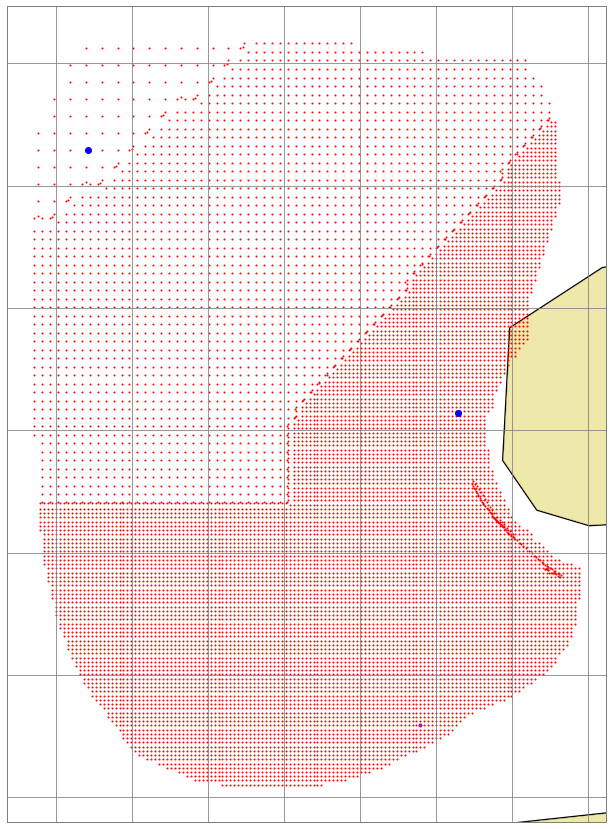

In [13]:
start = [3.66875   , 51.70416667]                     # Location of the koppelpunt                             (lon, lat)
stop = [3.522637481591586,51.76880095558772]

plt.figure(figsize=(15,15))
ax = plt.axes(projection=ccrs.Mercator())
plt.plot(flow.nodes[:,1],flow.nodes[:,0], 'r.',markersize = 2, transform=ccrs.PlateCarree())
ax.coastlines(resolution='10m', color='black', linewidth=3)
ax.gridlines(color = 'grey', zorder = 3)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='palegoldenrod'))

plt.plot(flow.nodes[244,1],flow.nodes[244,0], 'm.',  transform=ccrs.PlateCarree())

plt.plot(start[0], start[1], 'bo', transform=ccrs.PlateCarree())
plt.plot(stop[0], stop[1], 'bo', transform=ccrs.PlateCarree())

plt.show()

In [7]:
# start_time = time.time()

# Roadmap   = Mesh_maker.Graph_flow_model(name_textfile_flow, 
#                                         dx_min, 
#                                         blend, 
#                                         nl, 
#                                         number_of_neighbor_layers, 
#                                         vship, 
#                                         Load_flow, 
#                                         WD_min,
#                                         WVPI,
#                                         WWL = WWL,
#                                         ukc = ukc,
#                                         compute_cost = Q_cost,
#                                         compute_co2 = Q_co2,
#                                         repeat = False,
#                                         nodes_index = np.arange(5088),
#                                         optimization_type=['time']
#                                        )

# stop_time = time.time()
# computation_time = stop_time - start_time
# print("the computational time is:", round(computation_time,2), "sec")

array([[663]], dtype=int64)

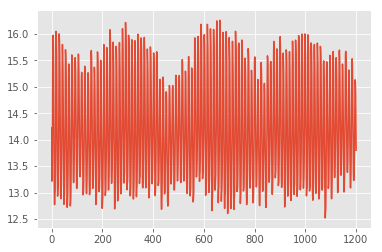

In [8]:
plt.plot(flow.WD[:,500])

np.argwhere(flow.WD[:,500] == flow.WD[:,500].max())

In [9]:
N = 200

x_r = np.arange(flow.nodes[:,1].min(), flow.nodes[:,1].max(), (flow.nodes[:,1].max() - flow.nodes[:,1].min())/N)
y_r = np.arange(flow.nodes[:,0].min(), flow.nodes[:,0].max(), (flow.nodes[:,0].max() - flow.nodes[:,0].min())/N)
y_r, x_r = np.meshgrid(y_r,x_r)

WD_r = griddata((flow.nodes[:,1], flow.nodes[:,0]), flow.WD[10,:], (x_r, y_r), method= 'linear')

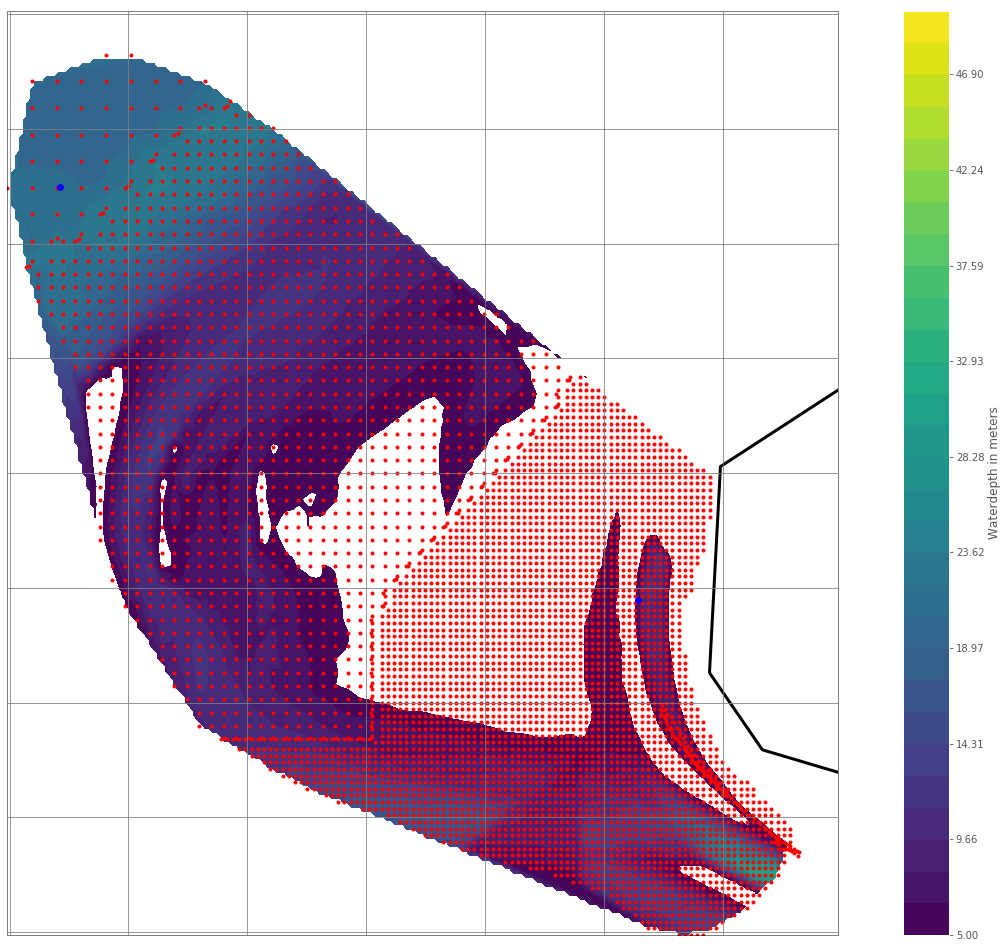

In [10]:
fig = plt.figure(figsize=(23, 17))
ax = plt.subplot(projection=ccrs.Mercator())
cval = np.linspace(5,50,30)
im = plt.contourf(x_r,y_r,WD_r,cval,transform=ccrs.PlateCarree())
fig.colorbar(im, ax=ax, label = 'Waterdepth in meters')

plt.plot(flow.nodes[:,1],flow.nodes[:,0], 'r.', transform=ccrs.PlateCarree())
ax.coastlines(resolution='10m', color='black', linewidth=3)
ax.gridlines(color = 'grey', zorder = 3)
#ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='palegoldenrod'))

plt.plot(flow.nodes[244,1],flow.nodes[244,0], 'm.',markersize = 0.1, transform=ccrs.PlateCarree())
plt.plot(start[0], start[1], 'bo', transform=ccrs.PlateCarree())
plt.plot(stop[0], stop[1], 'bo', transform=ccrs.PlateCarree())

In [11]:
start_time = time.time()

t0 = '01/04/2017 20:00:00'
route, route_t, route_dist = halem.HALEM_time(start, stop,t0, 5.9, Roadmap)

stop_time = time.time()
computation_time = stop_time - start_time
print("the computational time is:", round(computation_time,2), "sec")

route, route_t, route_dist

NameError: name 'Roadmap' is not defined

In [ ]:
start = [3.672   , 51.710] 

D_emp = 4.0
D_full = 8.0
ukc = 1.0

fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(projection=ccrs.Mercator())

cval = [-1000,D_emp +ukc, D_full+ukc, 100]
im = plt.contourf(x_r,y_r,WD_r,cval,transform=ccrs.PlateCarree(), colors = ('sandybrown', 'cornflowerblue', 'darkblue'))
fig.colorbar(im, ax=ax, label = 'Waterdepth in meters')

cval2 = [D_emp+ukc, D_full+ukc]
plt.contour(x_r,y_r,WD_r,cval2,transform=ccrs.PlateCarree(), colors = 'black', zorder = 1)

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='palegoldenrod'))
ax.coastlines(resolution='10m', color='darkgoldenrod', linewidth=3)


ax.gridlines(color = 'grey', zorder = 3)
plt.plot(flow.nodes[:,1],flow.nodes[:,0], 'r.',markersize = 2, transform=ccrs.PlateCarree())


plt.plot(start[0], start[1],'bo',transform=ccrs.PlateCarree(), label =  'Pumping location', markersize = 10)
plt.plot(stop[0], stop[1], 'go',transform=ccrs.PlateCarree() , label = 'Dredging location', markersize = 10)

# plt.plot(route[:,0], route[:,1], 'm' ,transform=ccrs.PlateCarree() , label = 'Dredging location', markersize = 10)


plt.legend(loc = 'best')
plt.show()

In [ ]:
datetime.datetime.fromtimestamp(Roadmap.t[1])

In [ ]:
Roadmap.vship